<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Rainforest%20Connection%20Species%20Audio%20Detection/banner.png" width="1000"></center>
<br>
<center><h1>Rainforest - Audio classification Tensorflow starter</h1></center>
<br>

#### References:
- [Simple audio recognition: Recognizing keywords](https://www.tensorflow.org/tutorials/audio/simple_audio)
- [RFCX: train resnet50 with TPU](https://www.kaggle.com/yosshi999/rfcx-train-resnet50-with-tpu)
- [Getting Started: Rainforest EDA with TFRecords](https://www.kaggle.com/jessemostipak/getting-started-rainforest-eda-with-tfrecords)

### Workflow diagram
```
1. Load TFRecords
2. Decode audio waveform
3. Crop audio waveform
4. Convert the waveform into spectrogram
4. Resize spectrogram
5. Turn grayscale spectrogram into RGB image
6. Feed to the model
```
 
<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Rainforest%20Connection%20Species%20Audio%20Detection/Rainforest%20diagram.jpg" width="1000"></center>

## Dependencies

In [1]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os, re, warnings, random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display as Idisplay
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
import efficientnet.tfkeras as efn
import tensorflow_addons as tfa

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

In [3]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [4]:
BATCH_SIZE = 16 * REPLICAS
LEARNING_RATE = 1e-3 * REPLICAS
EPOCHS = 15
HEIGHT = 224
WIDTH = 512
CHANNELS = 3
N_CLASSES = 24
ES_PATIENCE = 3
TTA_STEPS = 6 # Do TTA if > 0 

# Load data

We have two different `.csv` files, `train_tp.csv` has the information of all true positive species labels and `train_fp.csv` has the information of all false positive species labels.

In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)


database_base_path = '/kaggle/input/rfcx-species-audio-detection/'
train_fp = pd.read_csv(f'{database_base_path}train_fp.csv')
train_tp = pd.read_csv(f'{database_base_path}train_tp.csv')

print(f'Train false positive samples: {len(train_fp)}')
display(train_fp.head())
print(f'Train true positive samples: {len(train_tp)}')
display(train_tp.head())

GCS_PATH = KaggleDatasets().get_gcs_path('rfcx-species-audio-detection')

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test/*.tfrec')

NUM_TRAINING_SAMPLES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_SAMPLES = count_data_items(TEST_FILENAMES)

print(f'GCS: train samples: {NUM_TRAINING_SAMPLES}')
print(f'GCS: test samples: {NUM_TEST_SAMPLES}')

Train false positive samples: 7781


recording_id  species_id  songtype_id    t_min       f_min    t_max  \
0    00204008d          21            1  13.8400   3281.2500  14.9333   
1    00204008d           8            1  24.4960   3750.0000  28.6187   
2    00204008d           4            1  15.0027   2343.7500  16.8587   
3    003b04435          22            1  43.2533  10687.5000  44.8587   
4    003b04435          23            1   9.1254   7235.1562  15.2091   

        f_max  
0   4125.0000  
1   5531.2500  
2   4218.7500  
3  13687.5000  
4  11283.3984

Train true positive samples: 1216


recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70

GCS: train samples: 4727
GCS: test samples: 1992


## Auxiliary functions

In [6]:
# Datasets utility functions
def decode_audio(audio_binary):
    """
        Decode a 16-bit PCM WAV file to a float tensor.
    """
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)
    return audio

def string_split_semicolon(column):
    split_labels_sc = tf.strings.split(column, sep=';')
    return split_labels_sc

def string_split_comma(column):
    split_labels_c = tf.strings.split(column, sep=',')
    return split_labels_c

def get_label_info(label_info):
    first_split = string_split_semicolon(label_info)
    remove_quotes = tf.strings.regex_replace(first_split, '"', "")
    label_info = string_split_comma(remove_quotes)
    return label_info

def get_spectrogram(waveform, padding=False, min_padding=48000):
    """
        Transforms a 'waveform' into a 'spectrogram', adding padding if needed.
    """
    waveform = tf.cast(waveform, tf.float32)
    if padding:
        # Padding for files with less than {min_padding} samples
        zero_padding = tf.zeros([min_padding] - tf.shape(waveform), dtype=tf.float32)
        # Concatenate audio with padding so that all audio clips will be of the same length
        waveform = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(waveform, frame_length=2048, frame_step=512, fft_length=2048)
    spectrogram = tf.abs(spectrogram)
    return spectrogram
    
def get_spectrogram_tf(example):
    """
        Transforms a 'waveform' tensor into a 'spectrogram'.
        Applied to a Tensorflow dataset.
    """
    audio = example['audio_wav']
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    example['audio_wav'] = spectrogram
    return example

def prepare_sample(example):
    """
        1. Resize samples to the expected size.
        2. Convert gray scales (1 channel) images to RGB (3 channels) format.
    """
    sample = example['audio_wav']
    sample = tf.image.resize(sample, [HEIGHT, WIDTH])
    sample = tf.image.grayscale_to_rgb(sample)
    example['audio_wav'] = sample
    return example

def crop_audio(audio, tmin, tmax, crop_size=10, sample_rate=48000, max_size=60):
    """
        Crops a 'waveform' file to have {crop_size} size given, {tmin}, {tmax}, {sample_rate} and {max_size}.
    """
    label_size = tmax - tmin
    
    if label_size >= crop_size: # No padding needed
        cut_min = tmin * sample_rate
        cut_max = (tmin + crop_size) * sample_rate
    else: # Needs padding
        if tmin <= (max_size - crop_size): # Pad at the end
            cut_min = tmin * sample_rate
            cut_max = (tmin + crop_size) * sample_rate
        else: # Pad at the beginning
            cut_min = (tmin - crop_size) * sample_rate
            cut_max = tmax * sample_rate
    
    # Casting tensors
    cut_min = tf.cast(cut_min, tf.int32)
    cut_max = tf.cast(cut_max, tf.int32)
    cut_size = tf.cast((crop_size*sample_rate), tf.int32)
    
    audio = audio[cut_min:cut_max] # croping the audio
    audio = audio[:cut_size] # making sure it has the max size
    
    audio = tf.reshape(audio, [cut_size]) # making sure it has the expected shape
    return audio

def random_crop_audio(audio, crop_size=10, sample_rate=48000, max_size=60):
    """
        Randomly crops a 'waveform' file to have {crop_size} size given, {sample_rate} and {max_size}.
    """
    start = tf.random.uniform([], minval=0, 
                              maxval=(max_size - crop_size), 
                              dtype=tf.int32)
    cut_min = start * sample_rate
    cut_max = (start + crop_size) * sample_rate
    
    # Casting tensors
    cut_min = tf.cast(cut_min, tf.int32)
    cut_max = tf.cast(cut_max, tf.int32)
    cut_size = tf.cast((crop_size*sample_rate), tf.int32)
    
    audio = audio[cut_min:cut_max] # croping the audio
    audio = audio[:cut_size] # making sure it has the max size
    
    audio = tf.reshape(audio, [cut_size]) # making sure it has the expected shape
    return audio

def read_tfrecord(example, labeled=True, inference=False):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode PCM WAV file.
        3. Break down the information from 'label_info' into other features.
        4. Crop the 'audio' waveform if needed.
        5. Returns the features as a dictionary.
    """
    TFREC_FORMAT = {
        'audio_wav': tf.io.FixedLenFeature([], tf.string), 
        'recording_id': tf.io.FixedLenFeature([], tf.string), 
        'label_info': tf.io.FixedLenFeature([], tf.string, default_value='-1,-1,0,0,0,0,1'), 
    }
        
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    audio = decode_audio(example['audio_wav'])
    
    # Break down 'label_info' into the data columns
    label_info = get_label_info(example['label_info'])
    species_id = tf.strings.to_number(tf.gather_nd(label_info, [0, 0]), tf.int32)
#     songtype_id = tf.strings.to_number(tf.gather_nd(label_info, [0, 1]), tf.int32)
    tmin = tf.strings.to_number(tf.gather_nd(label_info, [0, 2]))
#     fmin = tf.strings.to_number(tf.gather_nd(label_info, [0, 3]))
    tmax = tf.strings.to_number(tf.gather_nd(label_info, [0, 4]))
#     fmax = tf.strings.to_number(tf.gather_nd(label_info, [0, 5]))
    is_tp = tf.strings.to_number(tf.gather_nd(label_info, [0, 6]), tf.int32)

    if labeled:
        audio = crop_audio(audio, tmin, tmax)
    if inference:
        audio = random_crop_audio(audio)
        
    features = {'audio_wav': audio, 
                'recording_id': example['recording_id'], 
                'species_id': species_id, 
                'is_tp': is_tp
               }
    return features

def load_dataset(filenames, labeled=True, ordered=False, inference=False):
    """
        Load and parse the TFRecords.
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(filenames)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)    
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled, inference=inference), num_parallel_calls=AUTO)
    return dataset

def conf_output(sample, labeled=True):
    """
        Configure the output of the dataset.
    """
    output = ({'input_audio': sample['audio_wav']}, sample['species_id'])
    return output

def get_dataset(filenames, labeled=True, ordered=False, repeated=False, inference=False):
    """
        1. Load TFRecord files, parse and generate features (waveform and meta-data).
        2. Filter the dataset to contain only true positive samples.
        3. Create 'spectrogram' from the 'waveform'.
        4. Prepare image for the model.
        5. Configure data to have the expected output format.
        6. Apply Tensorflow data functions to optimize training.
        
        Returns a Tensorflow dataset ready for training or inference.
    """
    dataset = load_dataset(filenames, labeled=labeled, inference=inference)
    
    if labeled:
        dataset = dataset.filter(_filtterTP)
    
    dataset = dataset.map(get_spectrogram_tf, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_sample, num_parallel_calls=AUTO)
    dataset = dataset.map(lambda x: conf_output(x, labeled=labeled), num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(256)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def _filtterTP(x):
    return x['is_tp'] == 1

In [7]:
# Visualization utility functions
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(spectrogram.shape[0])
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    
def display_waveforms(ds, n_rows=3, n_cols=3, figsize=(20, 16)):
    n = n_rows*n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, sample in enumerate(ds.take(n)):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        ax.plot(sample['audio_wav'].numpy())
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        label = sample['species_id'].numpy()
        recording_id = sample['recording_id'].numpy().decode()
        ax.set_title(f'{recording_id} - {label}')
    plt.show()
    
def display_spectrograms(ds, n_rows=3, n_cols=3, figsize=(20, 16)):
    n = n_rows*n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, sample in enumerate(ds.take(n)):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        plot_spectrogram(np.squeeze(sample['audio_wav'].numpy()), ax)
        label = sample['species_id'].numpy()
        recording_id = sample['recording_id'].numpy().decode()
        ax.set_title(f'{recording_id} - {label}')
    plt.show()
    
def inspect_preds(features, labels, preds, n_rows=3, n_cols=2, figsize=(20, 16)):
    n = n_rows*n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, (feature, label, pred) in enumerate(zip(features, labels, preds)):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        plot_spectrogram(np.squeeze(feature), ax)
        if pred == label:
            color = 'black'
            title = f'{pred} [True]'
        else:
            color = 'red'
            title = f'{pred} [False, should be {label}]'
        ax.set_title(title, fontsize=14, color=color)
    plt.show()
        
def display_waveforms_audio_spectrogram(ds, n_samples=1, sample_rate=48000):
    for sample in ds.take(n_samples):
        waveform = sample['audio_wav']
        label = sample['species_id'].numpy()
        recording_id = sample['recording_id'].numpy().decode()
        spectrogram = get_spectrogram(waveform)

        print(f'Name: {recording_id}')
        print(f'Label: {label}')
        print(f'Waveform shape: {waveform.shape}')
        print(f'Spectrogram shape: {spectrogram.shape}')
        print(f'Audio playback')
        Idisplay.display(Idisplay.Audio(waveform, rate=sample_rate))
        
        fig, axes = plt.subplots(2, figsize=(12, 8))
        timescale = np.arange(waveform.shape[0])
        axes[0].plot(timescale, waveform.numpy())
        axes[0].set_title('Waveform')
        axes[0].set_xlim([0, waveform.shape[0]])
        plot_spectrogram(spectrogram.numpy(), axes[1])
        axes[1].set_title('Spectrogram')
        plt.show()
        
def inspect_preds(features, labels, preds, n_rows=3, n_cols=2, figsize=(20, 16)):
    n = n_rows*n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, (feature, label, pred) in enumerate(zip(features, labels, preds)):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        
        feature = tf.image.rgb_to_grayscale(feature).numpy()
        plot_spectrogram(np.squeeze(feature), ax)
        if pred == label:
            color = 'black'
            title = f'{pred} [True]'
        else:
            color = 'red'
            title = f'{pred} [False, should be {label}]'
        ax.set_title(title, fontsize=14, color=color)
    plt.show()
    
# Model evaluation
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(20, 8))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best', fontsize=16)
    axes[0].set_title('Loss')
    axes[0].axvline(np.argmin(history['loss']), linestyle='dashed')
    axes[0].axvline(np.argmin(history['val_loss']), linestyle='dashed', color='orange')
    
    axes[1].plot(history['sparse_categorical_accuracy'], label='Train accuracy')
    axes[1].plot(history['val_sparse_categorical_accuracy'], label='Validation accuracy')
    axes[1].legend(loc='best', fontsize=16)
    axes[1].set_title('Accuracy')
    axes[1].axvline(np.argmax(history['sparse_categorical_accuracy']), linestyle='dashed')
    axes[1].axvline(np.argmax(history['val_sparse_categorical_accuracy']), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

# Reading audio files

The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [tf.audio.decode_wav](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. Note that [tf.audio.decode_wav](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav) will normalize the values to the range [-1.0, 1.0].

#### Let's examine a few audio waveforms with their corresponding labels.

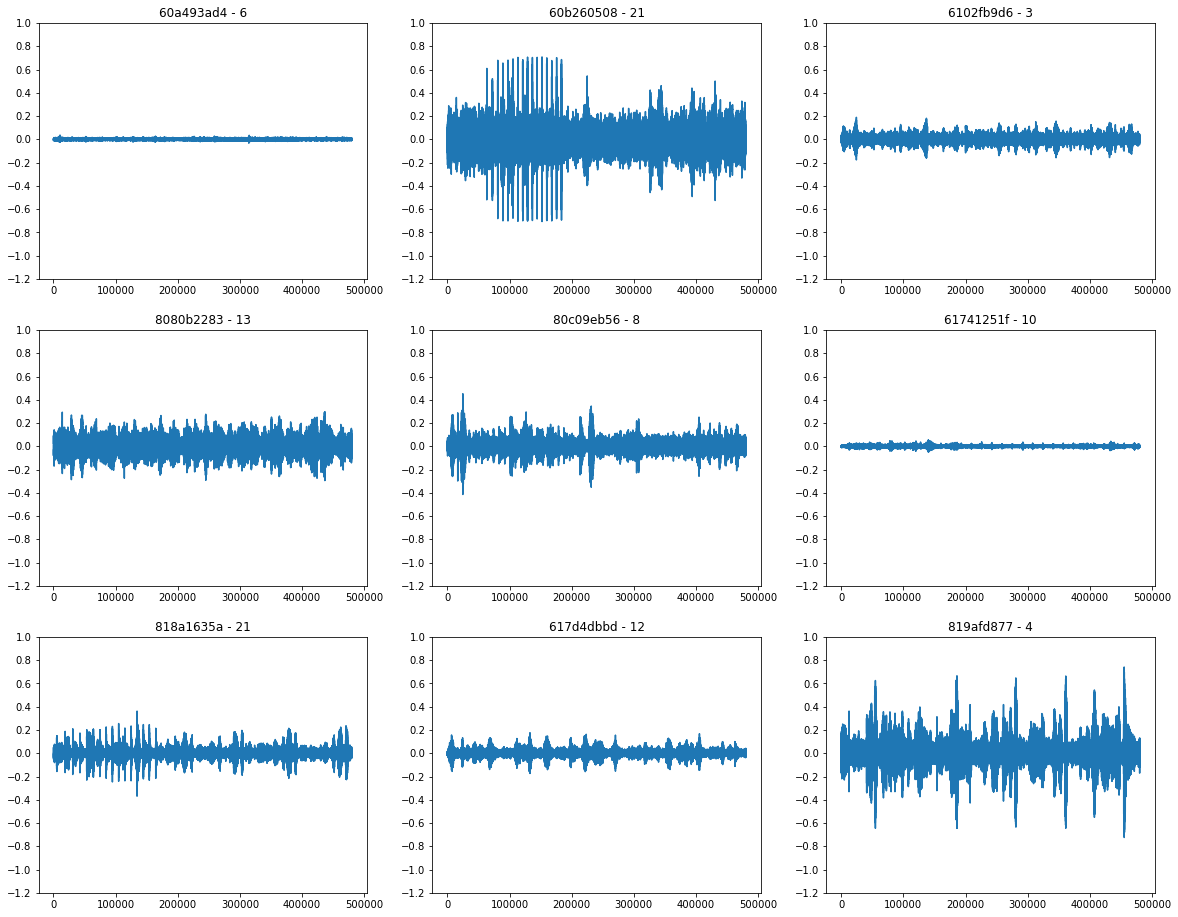

In [8]:
train_waveform_ds = load_dataset(TRAINING_FILENAMES)

display_waveforms(train_waveform_ds)

# Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([tf.signal.fft](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([tf.signal.stft](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying [tf.abs](https://www.tensorflow.org/api_docs/python/tf/math/abs) on the output of [tf.signal.stft](https://www.tensorflow.org/api_docs/python/tf/signal/stft).

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing.

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of a few examples from the dataset.

Name: c36ea621f
Label: 20
Waveform shape: (480000,)
Spectrogram shape: (934, 1025)
Audio playback


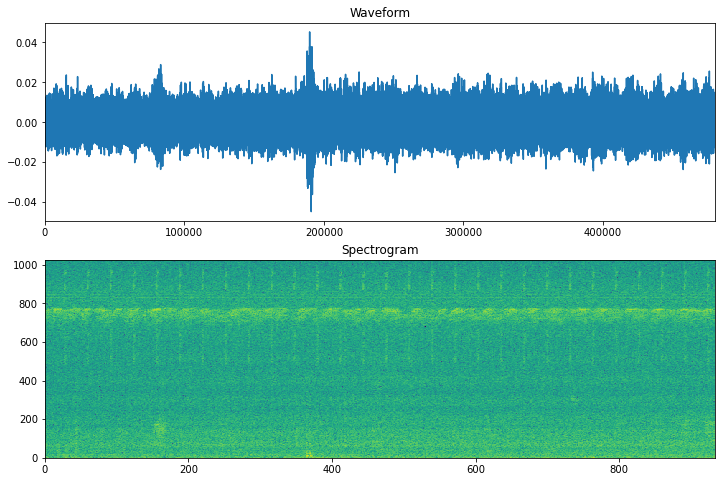

Name: c37acb1eb
Label: 20
Waveform shape: (480000,)
Spectrogram shape: (934, 1025)
Audio playback


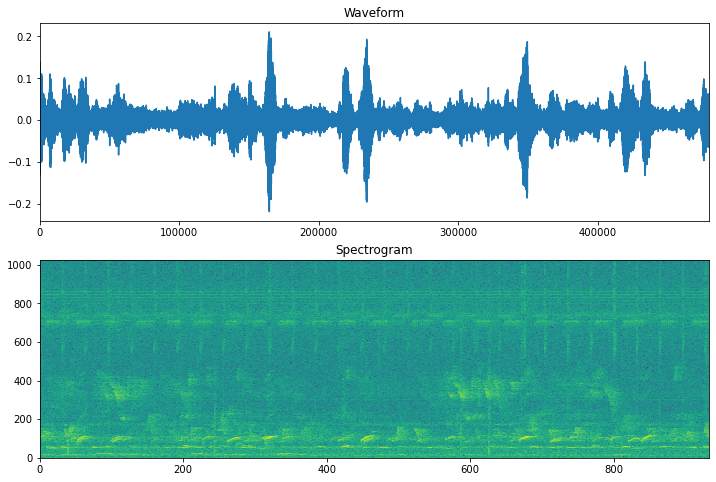

Name: c38932af9
Label: 10
Waveform shape: (480000,)
Spectrogram shape: (934, 1025)
Audio playback


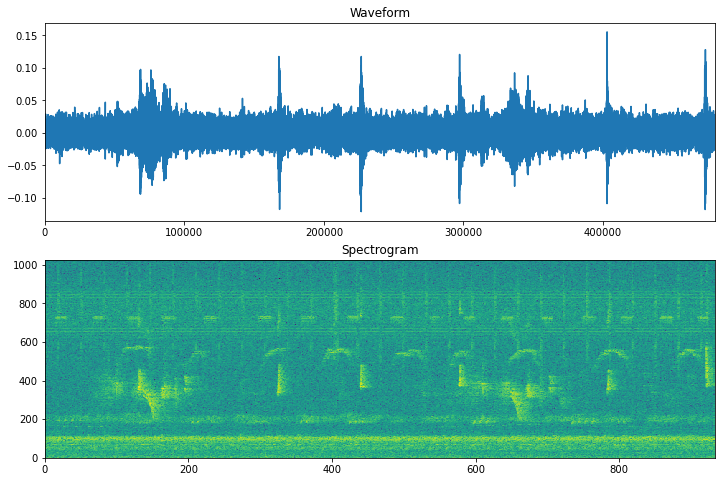

In [9]:
display_waveforms_audio_spectrogram(train_waveform_ds, n_samples=3)

Examine the spectrogram "images" for different samples of the datasets.

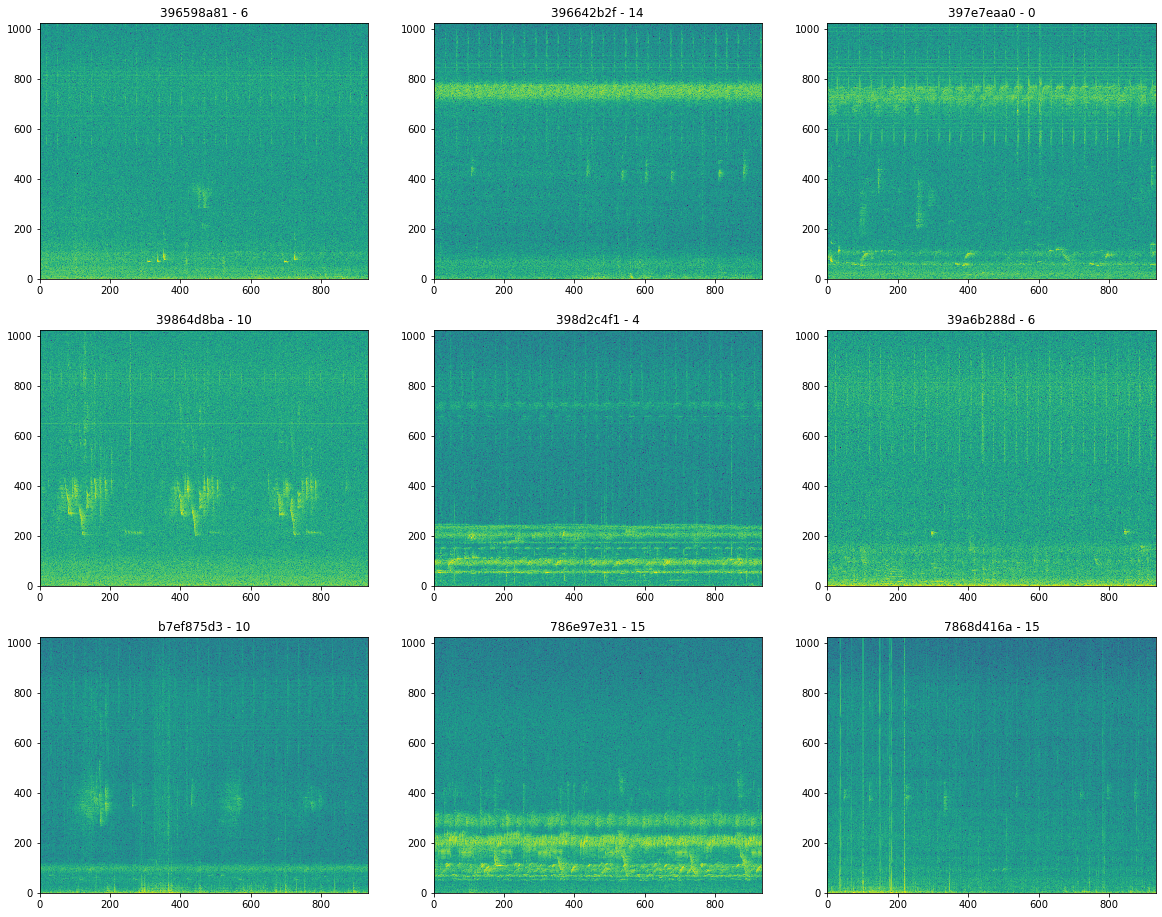

In [10]:
train_spectrogram_ds = train_waveform_ds.map(get_spectrogram_tf, num_parallel_calls=AUTO)

display_spectrograms(train_spectrogram_ds)

# Model

In [11]:
def model_fn(input_shape, N_CLASSES):
    inputs = L.Input(shape=input_shape, name='input_audio')
    base_model = efn.EfficientNetB0(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student',
                                    drop_connect_rate=0.4)

    x = L.GlobalAveragePooling2D()(base_model.output)
    x = L.Dropout(.5)(x)
    output = L.Dense(N_CLASSES, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=output)

    return model

# Training

In [12]:
oof_pred = []; oof_labels = []
idxT, idxV = train_test_split(range(32), test_size=0.2, random_state=seed)

# Create train and validation sets
TRAIN_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/tfrecords/train/%.2i*.tfrec' % x for x in idxT])
VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/tfrecords/train/%.2i*.tfrec' % x for x in idxV])
np.random.shuffle(TRAINING_FILENAMES)
ct_train = count_data_items(TRAIN_FILENAMES)
ct_valid = count_data_items(VALID_FILENAMES)
steps_per_epoch = 32 #(ct_train // BATCH_SIZE)

print(f'TRAIN: {idxT} | {ct_train} samples')
print(f'VALID: {idxV} | {ct_valid} samples')

## MODEL
with strategy.scope():
    model = model_fn((None, None, CHANNELS), N_CLASSES)

    model.compile(optimizer=tfa.optimizers.RectifiedAdam(lr=LEARNING_RATE, 
                                                         min_lr=1e-8, 
                                                         total_steps=int(steps_per_epoch*EPOCHS), 
                                                         warmup_proportion=0.3), 
                  loss=losses.SparseCategoricalCrossentropy(), 
                  metrics=[metrics.SparseCategoricalAccuracy()])

model_path = f'model.h5'
es = EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', 
                   patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

## TRAIN
history = model.fit(x=get_dataset(TRAIN_FILENAMES, labeled=True, ordered=False, repeated=True), 
                    validation_data=get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False), 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=EPOCHS, 
                    callbacks=[es], 
                    verbose=2).history

# Save last model weights
model.save_weights(model_path)

# OOF predictions
ds_valid = get_dataset(VALID_FILENAMES, labeled=True, ordered=True, repeated=False)
oof_labels.append([target.numpy() for x, target in iter(ds_valid.unbatch())])
x_oof = ds_valid.map(lambda x, target: x)
oof_pred.append(np.argmax(model.predict(x_oof), axis=-1))

## RESULTS
print(f"#### Accuracy = {np.max(history['val_sparse_categorical_accuracy']):.3f}")

TRAIN: [26, 20, 13, 24, 5, 17, 8, 30, 25, 23, 1, 31, 6, 4, 18, 29, 19, 9, 7, 27, 3, 0, 21, 15, 12] | 3691 samples
VALID: [11, 22, 10, 2, 16, 14, 28] | 1036 samples
16703488/16696600 [==============================] - 1s 0us/step
Epoch 1/15
32/32 - 88s - loss: 3.1893 - sparse_categorical_accuracy: 0.0581 - val_loss: 3.1740 - val_sparse_categorical_accuracy: 0.0743
Epoch 2/15
32/32 - 69s - loss: 2.6011 - sparse_categorical_accuracy: 0.2444 - val_loss: 2.7034 - val_sparse_categorical_accuracy: 0.1554
Epoch 3/15
32/32 - 66s - loss: 1.3922 - sparse_categorical_accuracy: 0.5972 - val_loss: 2.5622 - val_sparse_categorical_accuracy: 0.3378
Epoch 4/15
32/32 - 68s - loss: 0.5244 - sparse_categorical_accuracy: 0.8406 - val_loss: 2.8882 - val_sparse_categorical_accuracy: 0.4054
Epoch 5/15
32/32 - 67s - loss: 0.3119 - sparse_categorical_accuracy: 0.9082 - val_loss: 3.1939 - val_sparse_categorical_accuracy: 0.3378
Epoch 6/15
32/32 - 74s - loss: 0.2355 - sparse_categorical_accuracy: 0.9294 - val_loss

## Model loss graph

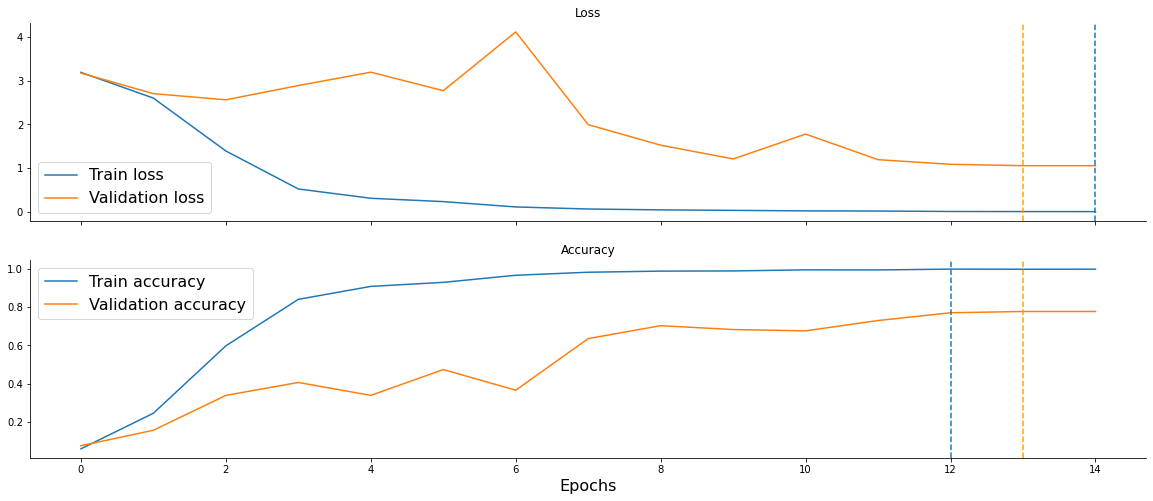

In [13]:
plot_metrics(history)

# Model evaluation

Now we can evaluate the performance of the model, first, we can evaluate the usual metrics like, `accuracy`, `precision`, `recall`, and `f1-score`, `scikit-learn` provides the perfect function for this `classification_report`.

## OOF metrics

In [14]:
y_true = np.concatenate(oof_labels)
y_pred = np.concatenate(oof_pred)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.55      0.46        11
           1       0.14      0.17      0.15         6
           2       0.00      0.00      0.00         0
           3       0.40      0.29      0.33         7
           4       0.25      0.33      0.29         3
           5       0.20      0.14      0.17         7
           6       0.50      0.40      0.44         5
           7       0.57      0.40      0.47        10
           8       0.00      0.00      0.00         8
           9       0.33      0.25      0.29         4
          10       0.00      0.00      0.00         4
          11       0.50      0.43      0.46         7
          12       0.30      0.33      0.32         9
          13       0.00      0.00      0.00         3
          14       0.17      0.14      0.15         7
          15       0.14      0.25      0.18         4
          16       0.22      0.25      0.24         8
          17       0.57    

# Confusion matrix

Let's also take a look at the confusion matrix, this will give us an idea about what classes the model is mixing or having a hard time.

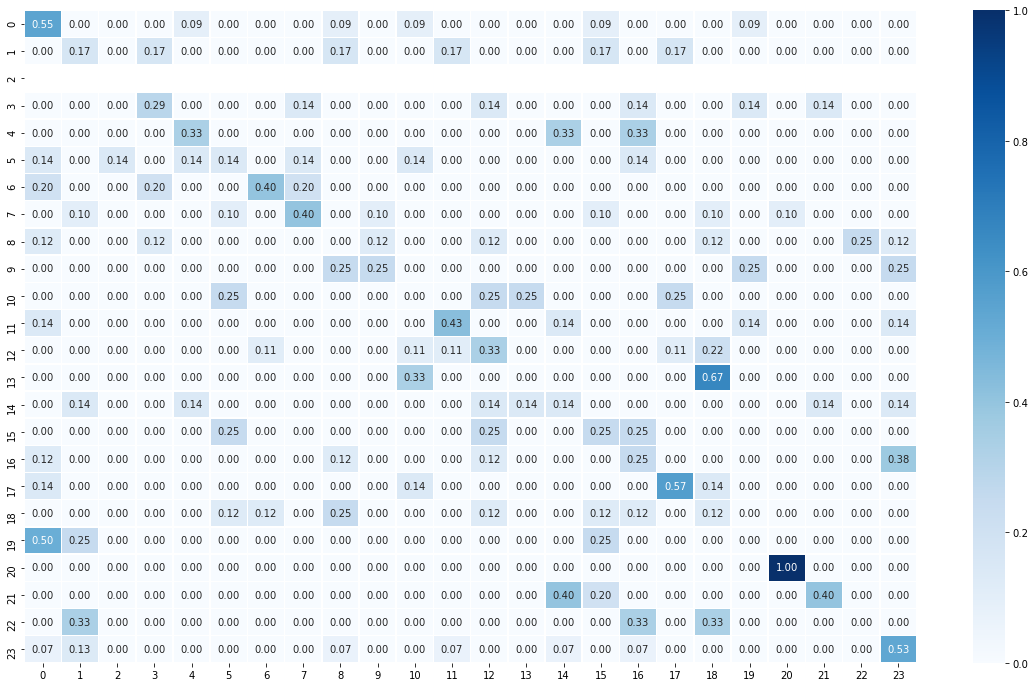

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred)
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5)
plt.show()

# Visualize predictions

Finally, it is a good practice to always inspect some of the model's prediction by looking at the data, this can give an idea if the model is getting some predictions wrong because the data is really hard, or if it is because the model is actually bad.

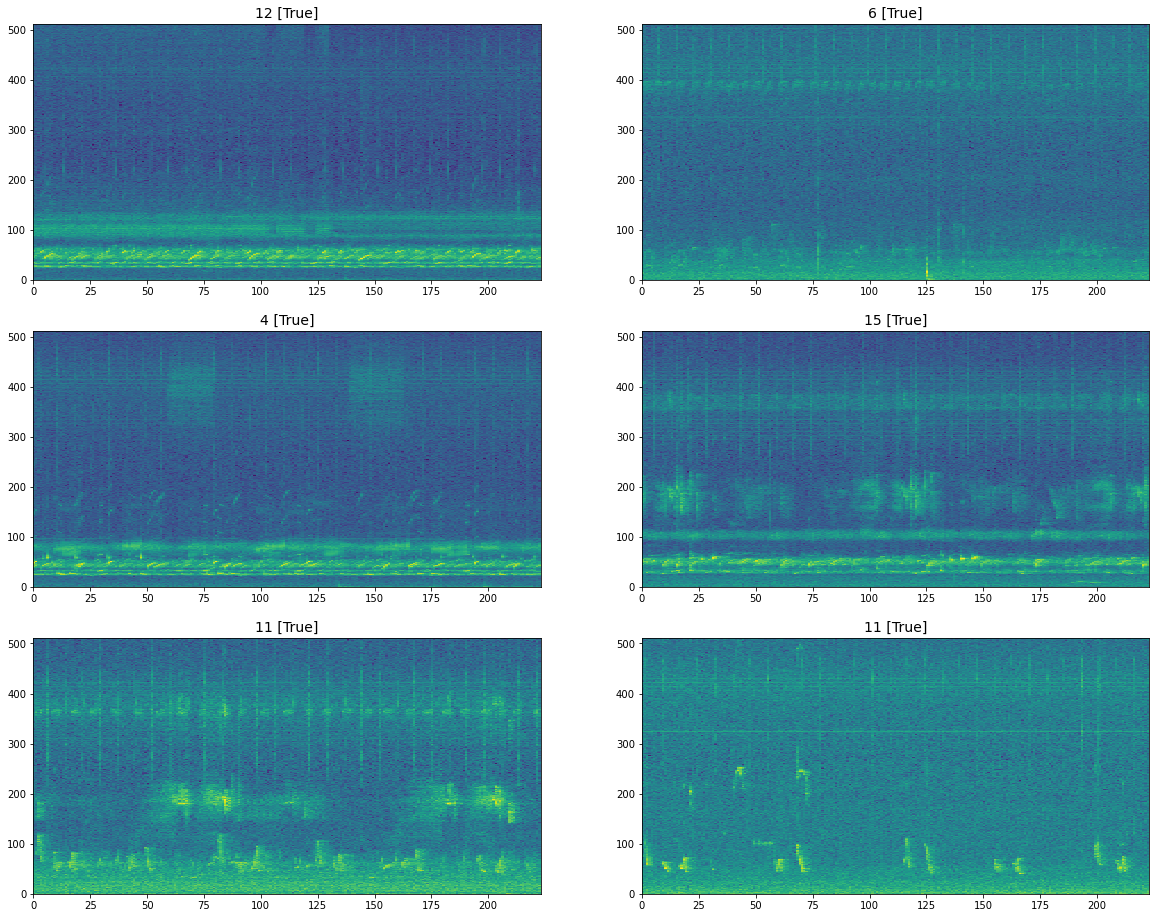

In [16]:
train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)

for features, label in train_dataset.take(1):
    preds = np.argmax(model.predict(features['input_audio']), axis=-1)[:6]
    labels = label.numpy()[:6]
    batch_features = features['input_audio'].numpy()[:6]
    
inspect_preds(batch_features, labels, preds)

# Test set predictions

In [17]:
test_size = count_data_items(TEST_FILENAMES)
test_ds = get_dataset(TEST_FILENAMES, labeled=False, ordered=True, repeated=True, inference=True)
ct_steps = TTA_STEPS * ((test_size/BATCH_SIZE) + 1)
x_test = test_ds.map(lambda features, recording_id: features['input_audio'])
test_preds = model.predict(x_test, steps=ct_steps, verbose=1)[:(test_size * TTA_STEPS)]
test_preds = np.mean(test_preds.reshape(test_size, TTA_STEPS, N_CLASSES, order='F'), axis=1)

names_test_ds = load_dataset(TEST_FILENAMES, labeled=False, ordered=True)
names = [features['recording_id'].numpy().decode('utf-8') for features in iter(names_test_ds)]

100/99 [==============================] - 55s 546ms/step


In [18]:
submission = pd.DataFrame({'recording_id': names})
for column in range(N_CLASSES):
    submission[f's{column}'] = test_preds[:, column]

submission.to_csv('submission.csv', index=False)
display(submission.head(10))

recording_id        s0        s1        s2        s3        s4        s5  \
0    000316da7  0.002133  0.000431  0.185833  0.016284  0.000123  0.008060   
1    097c4f536  0.005065  0.001186  0.471587  0.164806  0.000166  0.009789   
2    1202a2650  0.009491  0.000840  0.001051  0.281353  0.000170  0.018719   
3    1b171eeb9  0.019491  0.002976  0.000247  0.411904  0.000016  0.001011   
4    226daf7a4  0.111900  0.000196  0.000524  0.233382  0.000392  0.000595   
5    2a855c952  0.000157  0.000388  0.161086  0.060137  0.000586  0.204927   
6    32d052d69  0.000270  0.000422  0.000510  0.329327  0.000151  0.022589   
7    3ba2bdb06  0.001443  0.000624  0.020430  0.228764  0.000366  0.012880   
8    422d116ec  0.004062  0.000498  0.167229  0.116946  0.000071  0.000935   
9    492b3dc52  0.000204  0.000549  0.167654  0.220125  0.037454  0.175944   

         s6        s7        s8  ...       s14       s15       s16       s17  \
0  0.000977  0.002488  0.001735  ...  0.303806  0.157660  0.000574  0.001646   
1  0.000118  0.127148  0.017012  ...  0.000581  0.010057  0.019943  0.000139   
2  0.001692  0.073593  0.000174  ...  0.000281  0.027545  0.001010  0.293808   
3  0.000175  0.194494  0.001851  ...  0.003317  0.003777  0.000141  0.000199   
4  0.017363  0.011306  0.000728  ...  0.004540  0.018146  0.166984  0.058415   
5  0.010277  0.000486  0.000053  ...  0.000234  0.000074  0.167240  0.079251   
6  0.000293  0.000656  0.000433  ...  0.166809  0.000073  0.171351  0.003519   
7  0.007705  0.068412  0.000046  ...  0.166787  0.166922  0.137165  0.008998   
8  0.166079  0.002144  0.016397  ...  0.005003  0.167623  0.000139  0.024074   
9  0.005577  0.154216  0.000530  ...  0.000962  0.006931  0.004784  0.006056   

        s18       s19       s20       s21       s22       s23  
0  0.000093  0.001029  0.006976  0.000023  0.130335  0.002047  
1  0.014013  0.000327  0.000536  0.002989  0.001590  0.014053  
2  0.001113  0.004234  0.000847  0.000014  0.083433  0.005667  
3  0.001442  0.000876  0.022455  0.000002  0.140026  0.068994  
4  0.081946  0.025826  0.030055  0.000106  0.002485  0.030695  
5  0.000300  0.003247  0.004307  0.000013  0.021769  0.220667  
6  0.000673  0.044832  0.003003  0.000027  0.001531  0.243754  
7  0.000167  0.132331  0.000488  0.000066  0.003495  0.021678  
8  0.035041  0.000346  0.004883  0.000026  0.076695  0.193698  
9  0.000315  0.008602  0.046778  0.072365  0.008973  0.075395  

[10 rows x 25 columns]

# Predicted classes distribution

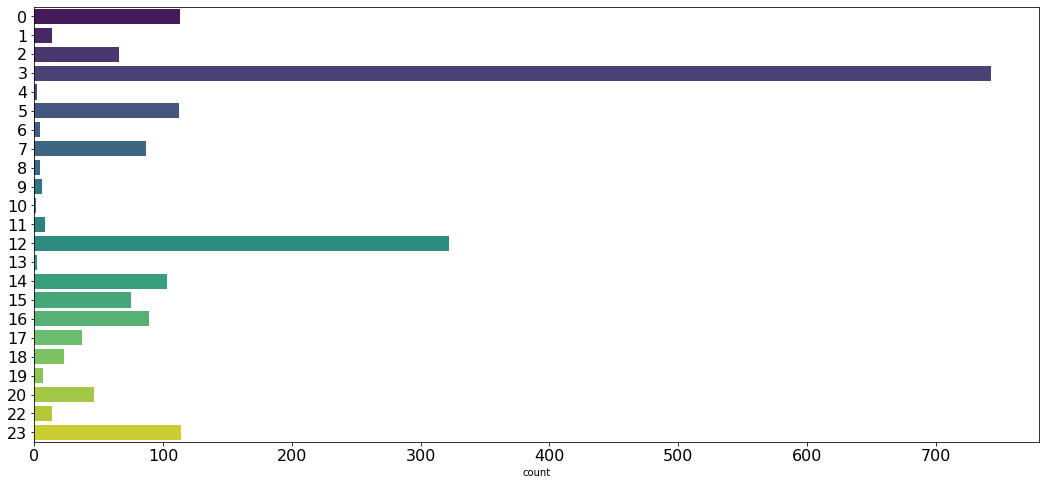

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax = sns.countplot(y=test_preds.argmax(axis=-1), palette='viridis')
ax.tick_params(labelsize=16)

plt.show()